- https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
- https://keras.io/applications/#resnet50
- https://www.kaggle.com/c/dogs-vs-cats/data

In [1]:
from distributed import Client

client = Client()
client

Client Scheduler: tcp://127.0.0.1:63988 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 17.18 GB


In [2]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

model = ResNet50(weights='imagenet')

Using TensorFlow backend.


Get the data:

https://www.kaggle.com/c/dogs-vs-cats/data

Or via the kaggle API.

Unzip

```
data/
  train/
    cat.0.jpg
    cat.1.jpg
    ...
  test1/
     1.jpg
     10.jpg
     ...
```

In [3]:
INPUT_SHAPE = (224, 224, 3)

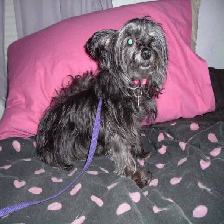

In [6]:
img = image.load_img("data/train/dog.0.jpg", target_size=(224, 224))
img

Here's the workflow for a single image:

1. Convert to an ndarray
2. Reshape
3. Preprocess for the network
4. Predict
5. Interpret

In [7]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)

decode_predictions(preds)

[[('n02102318', 'cocker_spaniel', 0.29664132),
  ('n02097298', 'Scotch_terrier', 0.14396866),
  ('n02097130', 'giant_schnauzer', 0.14393654),
  ('n02110627', 'affenpinscher', 0.10783948),
  ('n02088094', 'Afghan_hound', 0.047536265)]]

We'll now apply that to a whole bunch of images in the directory.
We'll parallelize this with dask.

In [24]:
import glob
from toolz import partition_all
from dask import delayed
import dask.array as da

In [10]:
client

Client Scheduler: tcp://127.0.0.1:63988 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 17.18 GB


We'll use `dask.delayed` to get our data into dask.

In [11]:
def load_one(path):
    img = image.load_img(path, target_size=INPUT_SHAPE[:2])
    return image.img_to_array(img)


def load_batch(paths):
    images = [load_one(path) for path in paths]
    return np.stack(images)

In [19]:
paths = glob.glob("data/train/*.jpg")

pairs = [(delayed(load_batch)(batch), len(batch)) for batch in partition_all(100, paths)]
pairs[0][0].compute().shape

(100, 224, 224, 3)

And to go from a delayed object to a dask Array, we use `da.from_delayed`.

In [28]:
obj, batch_size = pairs[0]
first = da.from_delayed(obj, (batch_size, 224, 224, 3), dtype='f4')
first.compute().shape

(100, 224, 224, 3)

Now let's do that for all our batches.

In [29]:
arrs = [da.from_delayed(obj, (batch_size, 224, 224, 3), dtype='f4')
        for obj, length in pairs]
arrs[:5]

[dask.array<from-value, shape=(100, 224, 224, 3), dtype=float32, chunksize=(100, 224, 224, 3)>,
 dask.array<from-value, shape=(100, 224, 224, 3), dtype=float32, chunksize=(100, 224, 224, 3)>,
 dask.array<from-value, shape=(100, 224, 224, 3), dtype=float32, chunksize=(100, 224, 224, 3)>,
 dask.array<from-value, shape=(100, 224, 224, 3), dtype=float32, chunksize=(100, 224, 224, 3)>,
 dask.array<from-value, shape=(100, 224, 224, 3), dtype=float32, chunksize=(100, 224, 224, 3)>]

In [30]:
X = da.concatenate(arrs, axis=0)
X

dask.array<concatenate, shape=(25000, 224, 224, 3), dtype=float32, chunksize=(100, 224, 224, 3)>

`X` is a 4-D dask array with one row per image.

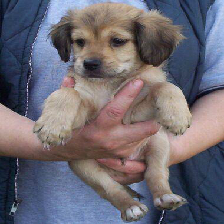

In [31]:
image.array_to_img(X[0])

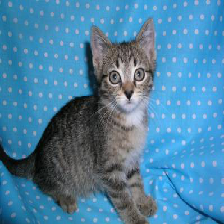

In [34]:
image.array_to_img(X[1])

In [33]:
decode_predictions(model.predict(X[:2]))

[[('n02085936', 'Maltese_dog', 0.41907966),
  ('n02113624', 'toy_poodle', 0.40274525),
  ('n02113712', 'miniature_poodle', 0.036060784),
  ('n02098413', 'Lhasa', 0.034490686),
  ('n02086240', 'Shih-Tzu', 0.033909038)],
 [('n02124075', 'Egyptian_cat', 0.3671553),
  ('n02127052', 'lynx', 0.30731118),
  ('n02123045', 'tabby', 0.03700487),
  ('n02123159', 'tiger_cat', 0.036151394),
  ('n04209239', 'shower_curtain', 0.029121857)]]

In [50]:
chunks = (X.chunks[0], (1000,))

In [51]:
%time res = X.map_blocks(model.predict, dtype='f4', drop_axis=(2, 3), chunks=chunks)

CPU times: user 1.44 s, sys: 411 ms, total: 1.85 s
Wall time: 1.81 s


In [52]:
res[0].compute()

ValueError: Tensor Tensor("fc1000/Softmax:0", shape=(?, 1000), dtype=float32) is not an element of this graph.

In [ ]:
0

In [16]:
len(glob.glob("data/train/*"))

25000